In [0]:
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.datasets import cifar10
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage
from sklearn.model_selection import train_test_split
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


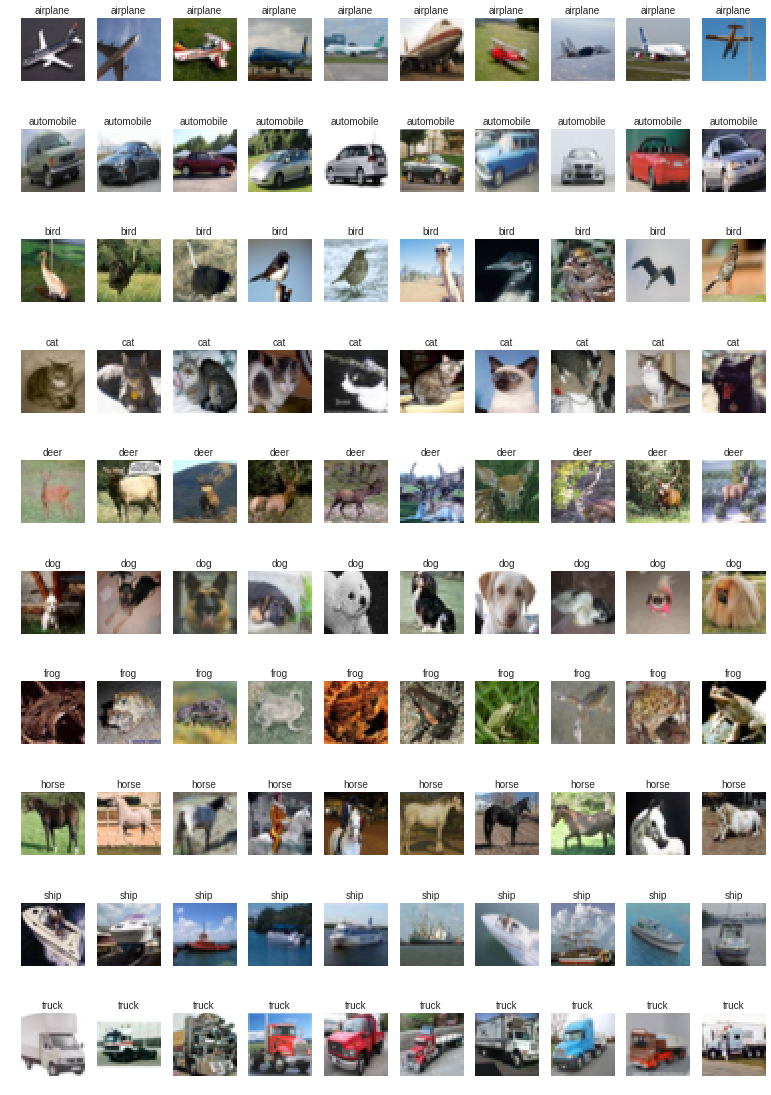

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import toimage

nclasses = 10
pos = 1
plt.figure(figsize=(16,24), dpi=60)

# matplotlib で学習用画像を10個ずつ表示する
# matplotlib はグラフを表示するためのライブラリでものすごく多機能なため、
# 便利ではあるがかなりとっつきづらい
# 細かい説明はキリがないので興味があれば調べてみてほしい。
for targetClass in range(nclasses):
    targetIdx = []
    # クラスclassIDの画像のインデックスリストを取得
    for i in range(len(y_train)):
        if y_train[i][0] == targetClass:
            targetIdx.append(i)

    # 各クラスからランダムに選んだ最初の10個の画像を描画
    np.random.shuffle(targetIdx)
    for idx in targetIdx[:10]:
        # X_train[idx] は3次元の行列になっており、そのままだと数字の羅列が表示されるだけなので
        # toimage を使って画像に変換してから表示する
        img = toimage(X_train[idx])
        plt.subplot(10, 10, pos)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cifar10_labels[y_train[idx][0]])
        pos += 1

plt.show()

In [0]:
# floatに変換しておく
# 正規化するために
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# 正規化
X_train /= 255.0
X_test /= 255.0
# RGB各要素について0-255の値で色を表現する、例えば白は（R 255、G 255、B 255）で表現

# one-hot vector に変換したほうが都合が良い
# たとえば 4 ではなくて [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] のようなデータにする
# こうしないとクラス分類ではなくて回帰として扱われてしまいうまくいかない
n_classes = 10
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [0]:
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


In [0]:
#
# ResNet のモデルを定義するセル
#

# inputs と residual 2つの処理結果を受け取って、両者を足す

# inputs：ショートカットせずに畳み込みやReLuなどをしたあとの信号
# residual：畳み込みなどを通らずショートカットして流れてくる信号のこと、つまりモジュールに入ってくる信号と同じ
def _shortcut(inputs, residual):
  
  # residual のほうのフィルタ数を取得する
  # ちなみにデフォルトでは
  # _keras_shape[1] 画像の幅
  # _keras_shape[2] 画像の高さ
  # _keras_shape[3] チャンネル数
  # チャンネル数、幅、高さの順番のこともあるが、今回はデフォルトでOK
  n_filters = residual._keras_shape[3]
  
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1x1 conv を使って residual 側のフィルタ数に合わせている
  shortcut = Convolution2D(n_filters, (1,1), strides=(1,1),kernel_initializer='glorot_normal', padding='same')(inputs)
 
  # 2つを足す
  return add([shortcut, residual])


# ResBlock を定義
# ここでの処理は BatchNorm → ReLU → Conv とシンプルなものにしてあるが、
# ここを色々変更する改良案が無数にある
def _resblock(n_filters, strides=(1,1)):
  def f(inputs):   

    x = Convolution2D(n_filters, (3,3), strides=strides,kernel_initializer='he_normal', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Convolution2D(n_filters, (3,3), strides=strides,kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    # 入力そのものと、BN→ReLU→Conv したものとを足す
    # この部分がResNetのもっとも重要な点
    return _shortcut(inputs, x)
  
  return f

In [0]:
def resnet():
    inputs = Input(shape=(32, 32, 3))
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = _resblock(n_filters=16)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = MaxPooling2D(strides=(2,2))(x)
    
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = _resblock(n_filters=32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = MaxPooling2D(strides=(2,2))(x)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = _resblock(n_filters=64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = MaxPooling2D(strides=(2,2))(x)

    x = _resblock(n_filters=128)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

In [0]:
model = resnet()
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_176 (BatchN (None, 32, 32, 3)    12          input_15[0][0]                   
__________________________________________________________________________________________________
activation_155 (Activation)     (None, 32, 32, 3)    0           batch_normalization_176[0][0]    
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 32, 32, 64)   1792        activation_155[0][0]             
__________________________________________________________________________________________________
batch_norm

In [0]:
#checkpoint
callback_op = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5')
callback_es = EarlyStopping(monitor='val_acc', patience=10,
                            mode='auto', verbose=1)

batch_size = 64
epochs = 100 # 普通は100〜300くらいを指定することが多い

h = model.fit(X_train, Y_train,
               batch_size=batch_size,
               epochs=epochs,
               validation_split=0.2,
               callbacks=[callback_op, callback_es])

model.save('model.hdf5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 43s 1ms/step - loss: 1.8835 - acc: 0.3168 - val_loss: 1.7500 - val_acc: 0.3745
Epoch 2/100
40000/40000 [==============================] - 34s 856us/step - loss: 1.6564 - acc: 0.4062 - val_loss: 1.6535 - val_acc: 0.3868
Epoch 3/100
40000/40000 [==============================] - 34s 855us/step - loss: 1.5272 - acc: 0.4575 - val_loss: 1.6561 - val_acc: 0.3962
Epoch 4/100
40000/40000 [==============================] - 34s 853us/step - loss: 1.4320 - acc: 0.4903 - val_loss: 1.4479 - val_acc: 0.4824
Epoch 5/100
40000/40000 [==============================] - 34s 852us/step - loss: 1.3657 - acc: 0.5132 - val_loss: 1.4570 - val_acc: 0.4638
Epoch 6/100
40000/40000 [==============================] - 34s 851us/step - loss: 1.3167 - acc: 0.5336 - val_loss: 1.3345 - val_acc: 0.5163
Epoch 7/100
40000/40000 [==============================] - 34s 850us/step - loss: 1.2777 - acc: 0.5463 - val_los

KeyboardInterrupt: ignored

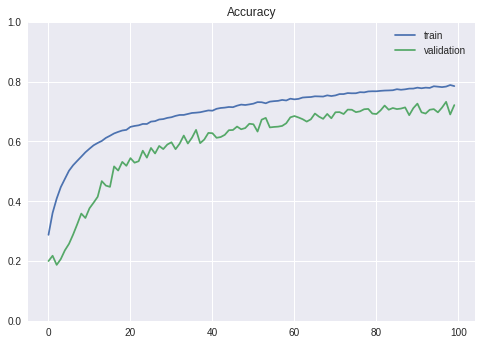

In [0]:
import numpy as np
import matplotlib.pyplot as plt

epoch = np.arange(len(h.history['acc']))

# accuracy と validation accuracy の推移をプロットする
plt.title('Accuracy')
plt.ylim(0.0, 1.0)
plt.plot(epoch, h.history['acc'], label='train')
plt.plot(epoch, h.history['val_acc'], label='validation')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


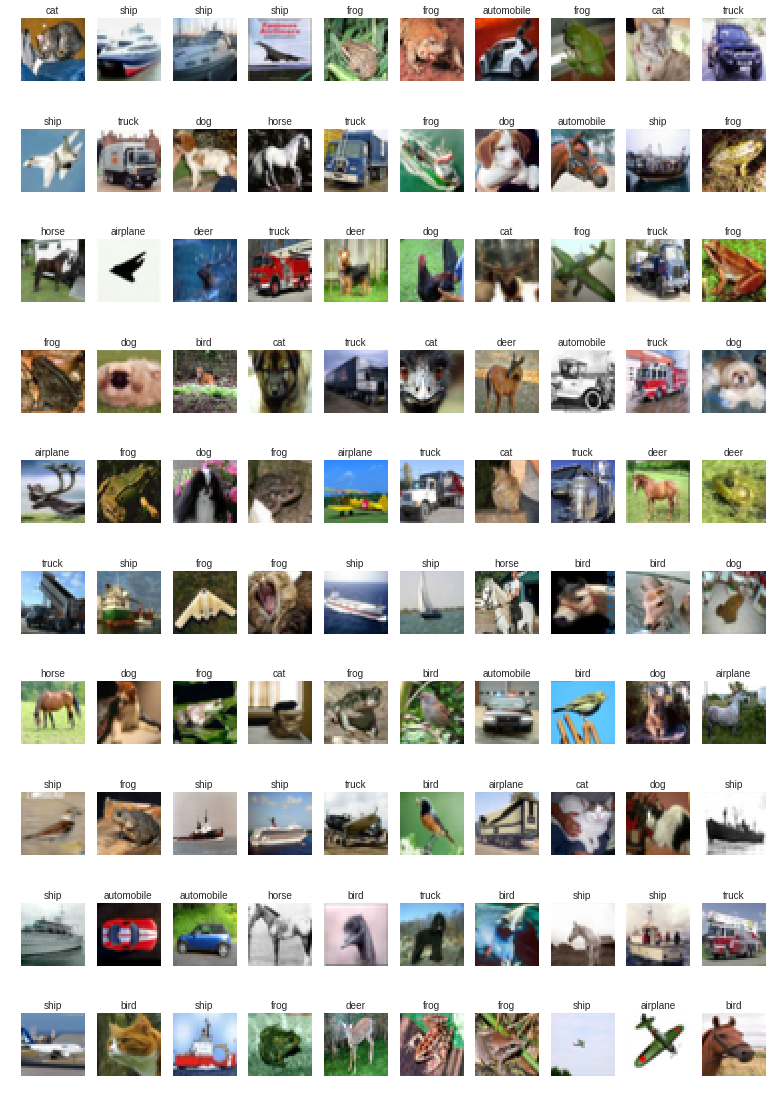

In [0]:
results = model.predict(X_test)

pos = 1
plt.figure(figsize=(16,24), dpi=60)

for i in range(100):
  img = toimage(X_test[i])
  label = results[i].argmax()
  plt.subplot(10, 10, pos)
  plt.imshow(img)
  plt.axis('off')
  plt.title(cifar10_labels[label])
  pos += 1        

plt.show()

In [0]:
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

#mixup
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=128, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        _, class_num = self.y_train.shape
        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])

        return X, y

#res block
def resblock(x, filters, kernel_size):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Activation("relu")(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#cnnの構築
input_ = Input(shape=(32, 32, 3))#横の数、縦の数、RGB

c = Conv2D(64, (1, 1), padding="same", kernel_initializer='he_normal')(input_)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = resblock(c,filters=64, kernel_size=(3, 3))
c = Conv2D(64, (3, 3), strides=2, kernel_initializer='he_normal')(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.2)(c)
c = resblock(c,filters=64, kernel_size=(3, 3))
c = Conv2D(128, (3, 3), strides=2, kernel_initializer='he_normal')(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.2)(c)
c = resblock(c,filters=128, kernel_size=(3, 3))
c = Conv2D(256, (3, 3), strides=2, kernel_initializer='he_normal')(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Dropout(0.2)(c)

c = GlobalAveragePooling2D()(c)
c = Dense(10, activation='softmax')(c)

model = Model(input_, c)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])


# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

#mixup
training_generator = MixupGenerator(X_train, Y_train, datagen=datagen)()

#cnnの学習
hist = model.fit_generator(generator=training_generator,
                           steps_per_epoch=X_train.shape[0] /128,
                           validation_data=(X_test, Y_test),
                           epochs=100, 
                           verbose=1)

#結果描画
plt.figure()               
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

plt.figure()               
plt.plot(hist.history['acc'],label="train_acc")
plt.plot(hist.history['val_acc'],label="val_acc")
plt.legend(loc="lower right")
plt.show()

Epoch 1/100
391/390 [==============================] - 63s 160ms/step - loss: 1.7250 - acc: 0.4030 - val_loss: 1.4862 - val_acc: 0.4889
Epoch 2/100
391/390 [==============================] - 51s 131ms/step - loss: 1.4481 - acc: 0.5325 - val_loss: 1.4192 - val_acc: 0.5144
Epoch 3/100
391/390 [==============================] - 51s 131ms/step - loss: 1.3162 - acc: 0.5953 - val_loss: 0.9584 - val_acc: 0.6696
Epoch 4/100
391/390 [==============================] - 51s 131ms/step - loss: 1.2148 - acc: 0.6377 - val_loss: 0.9529 - val_acc: 0.6716
Epoch 5/100
391/390 [==============================] - 51s 131ms/step - loss: 1.1486 - acc: 0.6674 - val_loss: 0.8470 - val_acc: 0.7139
Epoch 6/100
391/390 [==============================] - 52s 132ms/step - loss: 1.0981 - acc: 0.6922 - val_loss: 0.9926 - val_acc: 0.6970
Epoch 7/100
391/390 [==============================] - 52s 132ms/step - loss: 1.0544 - acc: 0.7126 - val_loss: 0.8084 - val_acc: 0.7390
Epoch 8/100
391/390 [===========================